# 가지치기
----

## 과대적합 문제

일반적인 트리 생성 방법은 과대적합(overfitting)이 발생하여 테스트 에러가 커질 가능성이 높다.
이는 각 리프 노드에 데이터가 하나만 남을 때까지 분할을 진행할 수 있기 때문이며, 그 결과 매우 많은 노드를 가진 복잡한 트리가 생성된다.

일반적으로 **분할 수가 적은 트리**는 약간의 bias를 감수하더라도 분산이 작고,
해석 가능성과 일반화 성능이 더 우수할 가능성이 높다.

한 가지 대안은, 어떤 분할이 **에러를 충분히 감소시키지 못할 경우** 해당 지점에서 트리 생성을 중단하는 것이다.

* 그러나 현재 단계의 분할이 에러를 크게 줄이지 못하더라도, 이후의 추가 분할을 통해 **트리 전체의 손실 함수**, 이러한 조기 중단 방식은 신중하게 적용해야 한다.

## Pruning a tree

더 나은 방법은 일단 큰 트리 $T_0$를 만든 후에 더 작은 트리로 pruning하는 방법 (cost complexity pruning)이다.

---

#### 기본 정의

먼저 다음을 정의하자.

* $\alpha > 0$ : nonnegative tuning parameter, 트리 복잡도에 대한 페널티를 조절. 

* $|T|$ : 트리 $T$의 terminal node 수

#### Cost Complexity Pruning 목적

각 $\alpha$에 대해 다음을 최소화하는 subtree $T \subset T_0$를 찾는다.

$$ \sum_{m=1}^{|T|} \sum_{i: x_i \in R_m} (y_i - \hat y_{R_m})^2 + \alpha |T| $$

* 첫 번째 항: **훈련 데이터에 대한 오차** (fitting 정도)
* 두 번째 항: **트리 크기에 비례한 페널티** ($\alpha |T|$)

> 즉, $\alpha$가 크면 트리 구조를 단순화하는 방향으로 가지치기가 진행된다.

#### $\alpha$의 역할

* 트리의 **complexity**와 훈련 데이터 **적합도(fitting)** 사이의 trade-off를 조절
* 최적 $\hat\alpha$는 **cross-validation**을 통해 선택 가능

> 작은 $\alpha$ → 큰 트리 유지, fitting 정확도 높음

> 큰 $\alpha$ → 작은 트리로 가지치기, 과적합 방지

### 최적 $\alpha$의 선택

실제 적용에서는 주어진 데이터 전체를 **training set**과 **test set**으로 나눈 후, training set을 이용해 여러 값의 $\alpha$에 대해 가지치기된 트리를 생성한다.

구체적인 절차는 다음과 같다.

1. Training set을 이용해 충분히 큰 트리 $T_0$를 적합한다.  
2. Cost complexity pruning을 적용하여 여러 후보 $\alpha$ 값에 대해 서로 다른 subtree들을 생성한다.  
3. 각 $\alpha$에 대해, training set으로 학습한 트리를 test set에 적용하여 **예측 오차**를 계산한다.  
   * 회귀 문제: mean squared error (MSE)  
   * 분류 문제: Gini/entropy 계수나 misclassification error 등 분류 성능 지표  
4. Test error를 최소화하는 $\alpha$를 선택하고, 이를 $\hat\alpha$로 둔다.

이 방법은 계산이 간단하고 직관적이지만, 데이터 분할 방식에 따라 결과가 달라질 수 있다는 단점이 있다.

이 단점을 완화하기 위해  **K-fold cross-validation**이 사용될 수 있다.

### K-fold Cross-Validation을 이용한 Cost Complexity Pruning

K-fold cross-validation의 경우, 일반적인 train-test split을 통한 validation set approach보다는 복잡하지만, 알고리즘을 요약하자면 다음과 같다.

#### Step 1: 최대 트리 생성

먼저 **recursive binary splitting**을 이용하여 가능한 한 큰 트리 $T_0$를 생성한다.
각 terminal node에 포함된 샘플 수가 미리 정한 최소값보다 작아질 때까지 분할을 반복한다.

#### Step 2: Cost Complexity Pruning 경로 계산

Cost complexity pruning을 적용하여 여러 값의 $\alpha$에 대해 최적의 subtree들을 구한다.

* 이론적으로 $\alpha$는 모든 양의 실수값을 가질 수 있으나,
  실제 계산에서는 **유한한 개수의 후보 $\alpha$** 값만 고려한다.
* 이 과정에서 각 $\alpha$에 대응하는 subtree가 결정된다.

#### Step 3: K-fold Cross-Validation을 통한 $\alpha$ 선택

$k = 1, \dots, K$에 대해 다음 과정을 반복한다.

* 전체 데이터를 $K$개로 나누고, $k$번째 fold를 검증 데이터로 제외한 나머지 $K-1$개 fold에 대해 Step 1과 Step 2를 수행한다.
* 가지치기된 트리를 이용해 $k$번째 fold에 대한 **예측 오차**를 계산한다.
    *  **회귀 문제** : mean squared prediction error (MSE)
    * **분류 문제** : Gini/entropy 기반 지표 등

모든 fold에 대해 계산된 예측 오차를 평균내어, 평균 예측 오차를 최소화하는 $\alpha$를 선택한다.

#### Step 4: 최종 트리 적합 및 예측

선택된 $\hat{\alpha}$를 이용하여 전체 학습 데이터에 대해 트리를 다시 적합시키고,
이를 최종 모델로 사용하여 예측을 수행한다.

### 야구선수 연봉 예제

야구선수 연봉 예제로 돌아가 다음 그림은 앞 예제에서 만들어낸 큰 트리이다.

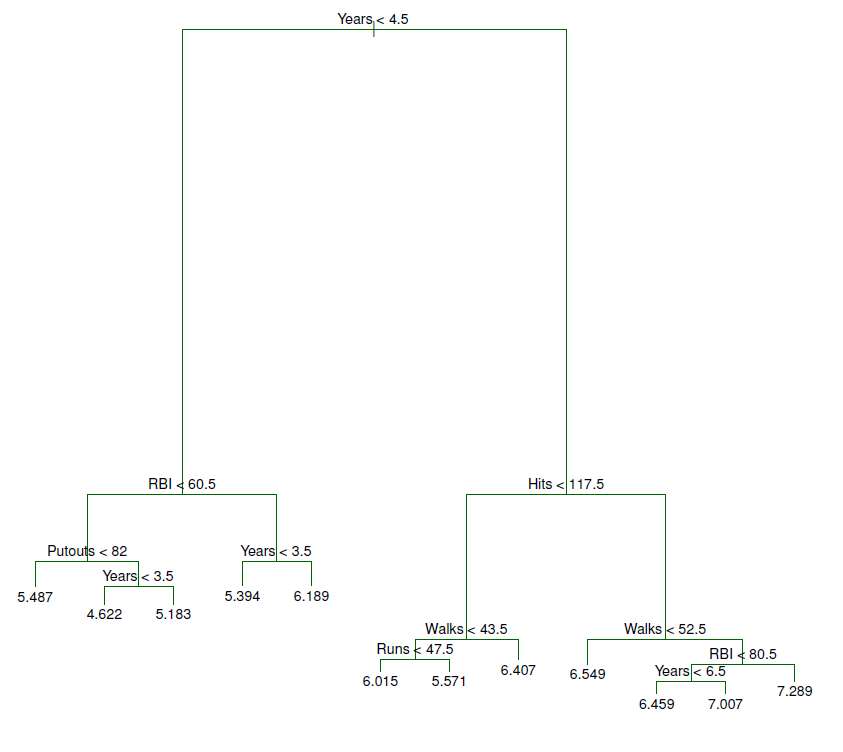

다음 그림은 validation error를 측정한 그림이다. 원래는 $\alpha$에 대해 작성되지만, $\alpha$는 tree 크기와 밀접하게 관련이 있고, tree 크기를 통해 나타내는 것이 보다 직관적이라 $x$-축은 tree의 크기로 되어 있다.

* **Training error**는 트리 크기가 커질수록 항상 감소하지만 과적합을 반영하지 못하므로 모델 선택에 사용할 수 없다.
* **Cross-validation error**는 보지 않은 데이터에 대한 예측 오차를 근사하며, 실제 **test error의 대리(proxy)** 역할을 한다.
  * 아래 그림에서처럼 CV error는 트리 크기에 따라 U자 형태를 보이며, 그 최소점이 가지치기된 트리 선택 기준이 된다.
* **Test error**는 학습과 모델 선택에 전혀 사용되지 않은 데이터로 계산되며, 최종 모델의 일반화 성능을 평가하는 데만 사용된다.
  * 여기서는 **CV error를 최소화하는 모델을 선택하고, test error는 그 선택의 타당성을 확인하는 용도로만 사용**한다.

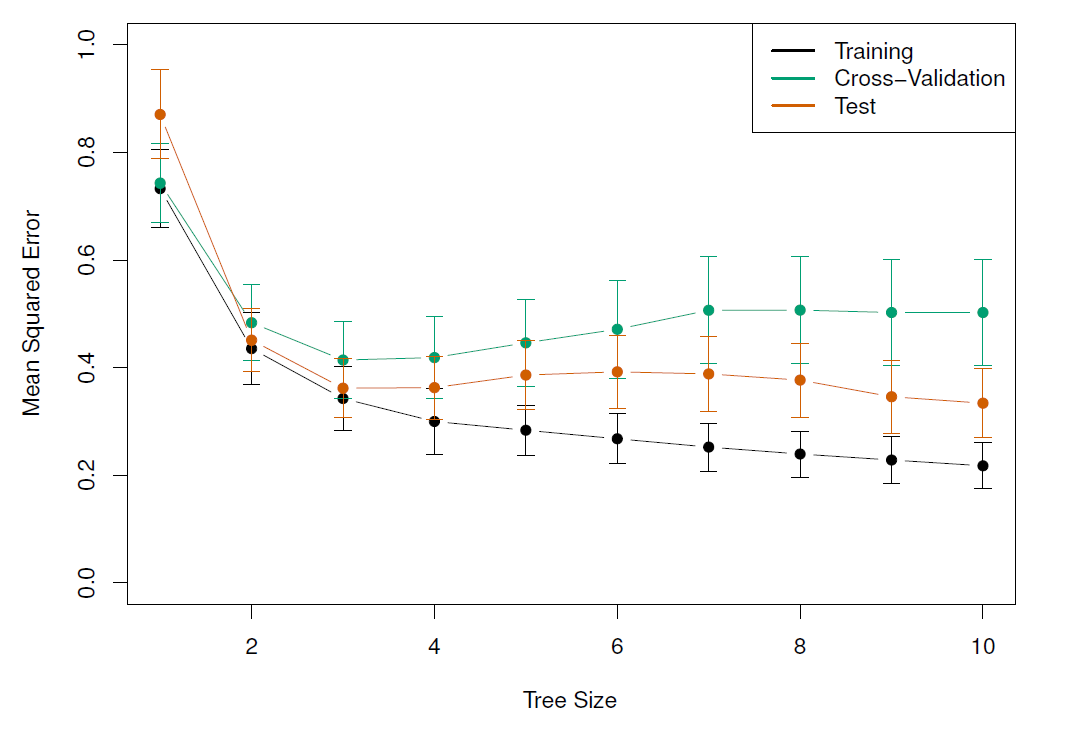

## Cost complexity pruning in `scikit-learn`


Pruning 알고리즘을 적용하기 위해, `scikit-learn`은 가지치기 프로세스의 각 단계에서 유효 알파 및 그에 해당하는 총 leaf impurity을 반환하는 [`DecisionTreeClassifier.cost_complexity_pruning_path`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path)를 제공한다. 

가지치기에 따른 복잡도 감소(리프 수 감소)와 불순도 증가를 비교해, 해당 가지를 제거할 때 최소한으로 필요한 $\alpha$값인 유효 $\alpha$를 계산한다.

즉, 이 함수는 트리의 각 pruning 단계에서 다음을 반환한다.

* effective alpha : 가지치기 시 필요한 최소 복잡도 페널티
* total leaf impurity: 해당 단계의 모든 리프 노드 불순도의 합


### 유효 알파 계산

어떤 내부 노드 $t$를 가지치기할 때의 유효 알파 $\alpha_t$는 다음과 같이 정의된다.

$$
\alpha_t = \frac{R(t) - R(T_t)}{|T_t| - 1}
$$

여기서

* $R(T_t)$: 서브트리 $T_t$의 총 불순도 (해당 서브트리의 모든 리프 노드 impurity의 합)
* $R(t)$: $t$ 노드 하나로 가지치기했을 때의 impurity (즉, $T_t$를 리프 하나로 대체)
* $|T_t|$: 서브트리 $T_t$의 리프 노드 수

즉, $\alpha_t$는 서브트리를 하나의 리프로 대체할 때 **불순도 증가 대비 복잡도 감소**를 나타낸 값이다.

* 유효 $\alpha$가 작을수록, 성능 손해 없이 복잡도만 줄일 수 있으며, 먼저 가지치기 된다.  
* 유효 $\alpha$가 클수록, 성능 손해가 크며, 가지치기의 우선 순위에서 밀린다.

또한, $\alpha_t$는

* `scikit-learn`의 `cost_complexity_pruning_path()` 함수에서 나오는 각 pruning 단계에서의 $\alpha$ 값  
* 즉, 실제로 트리 가지치기를 실행하면서 이 노드를 가지치기할 경우 가장 적절한(최소한의) $\alpha$ 값이 얼마인지를 계산한 값.

### Minimal Cost Complexity Pruning

이를 통해 가장 작은 유효 $\alpha$를 가지는 노드부터 가지치기하는 minimal cost complexity pruning를 구현할 수 있는데,
이는 재귀적으로 "가장 약한 링크"를 가진 노드를 찾아 가지치기 하는 행위이다. 

아래 예제에서는 k-fold 교차검증 대신, 단순 train-test split을 통한 validation set approach를 통해 가지치기 결과를 확인하는 방식을 보여준다.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X, y = load_breast_cancer(return_X_y = True)
X[1]

array([2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
       8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
       3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
       1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
       1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02])

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = tree.DecisionTreeClassifier(random_state=0)

In [4]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00226647, 0.00464743, 0.0046598 , 0.0056338 ,
        0.00704225, 0.00784194, 0.00911402, 0.01144366, 0.018988  ,
        0.02314163, 0.03422475, 0.32729844]),
 'impurities': array([0.        , 0.00453294, 0.01847522, 0.02313502, 0.02876883,
        0.03581108, 0.04365302, 0.05276704, 0.0642107 , 0.0831987 ,
        0.10634033, 0.14056508, 0.46786352])}

위 결과에 따르면 $\alpha = 0.00226647$일 때, 가장 약한 노드를 제거할 수 있다. 

이 때, 트리의 impurity는 0.00453294만큼 증가한다.

그리고, $\alpha = 0.00464743$일 때, 다음으로 약한 노드를 제거할 수 있으며, impurity는 원래 트리 대비 총 0.01847522만큼 증가한다.

In [5]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities
df = pd.DataFrame({
    "Step": range(len(ccp_alphas)),
    "Effective Alpha (ccp_alpha)": ccp_alphas,
    "Total Leaf Impurity": impurities
})

df = df.round(6)

print(df)

    Step  Effective Alpha (ccp_alpha)  Total Leaf Impurity
0      0                     0.000000             0.000000
1      1                     0.002266             0.004533
2      2                     0.004647             0.018475
3      3                     0.004660             0.023135
4      4                     0.005634             0.028769
5      5                     0.007042             0.035811
6      6                     0.007842             0.043653
7      7                     0.009114             0.052767
8      8                     0.011444             0.064211
9      9                     0.018988             0.083199
10    10                     0.023142             0.106340
11    11                     0.034225             0.140565
12    12                     0.327298             0.467864


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

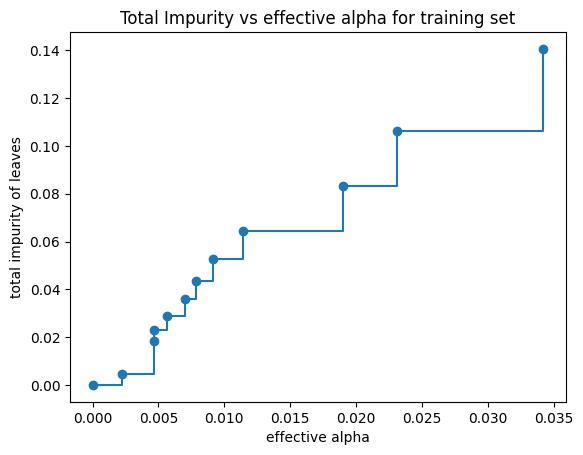

In [6]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

[`tree_`](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) 속성은 underlying tree object를 반환하며, 트리 구조를 담고 있다.

In [7]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3272984419327777


가장 마지막은 tree라기 보다는 원본 데이터 그 자체이다.

[Text(0.5, 0.5, 'gini = 0.468\nsamples = 426\nvalue = [159, 267]')]

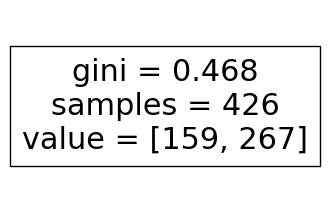

In [8]:
plt.figure(figsize=(4,2.5))
tree.plot_tree(clfs[-1])

그래서 마지막 것을 제외하고 트리들의 리스트를 다시 구성하였다.

In [9]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
clfs

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.0022664723976040134, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.004647426339100881, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.004659799593581376, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.005633802816901408, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.007042253521126761, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.007841938420144537, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.009114019793328328, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.011443661971830986, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.018988002086593604, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.023141627543035996, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.03422474765119576, random_state=0)]

`clfs` 리스트의 아무거나 가져와서 내용을 살펴보기

In [10]:
clfs[10].tree_.node_count

5

[Text(0.4, 0.8333333333333334, 'x[7] <= 0.049\ngini = 0.468\nsamples = 426\nvalue = [159, 267]'),
 Text(0.2, 0.5, 'gini = 0.095\nsamples = 260\nvalue = [13, 247]'),
 Text(0.6, 0.5, 'x[23] <= 785.8\ngini = 0.212\nsamples = 166\nvalue = [146, 20]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.491\nsamples = 30\nvalue = [13, 17]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 136\nvalue = [133, 3]')]

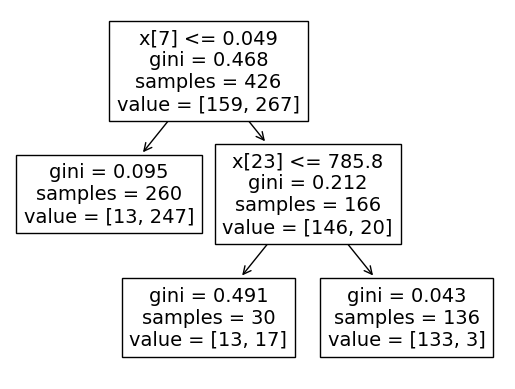

In [11]:
tree.plot_tree(clfs[-2])

In [12]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

In [13]:
node_counts

[31, 27, 21, 19, 17, 15, 13, 11, 9, 7, 5, 3]

In [14]:
depth

[8, 6, 4, 4, 4, 4, 4, 4, 3, 3, 2, 1]

아래 코드는 cost complexity pruning 과정에서 $\alpha$값이 증가함에 따라 트리 구조가 어떻게 단순화되는지를 시각적으로 보여주기 위한 그림을 생성한다.

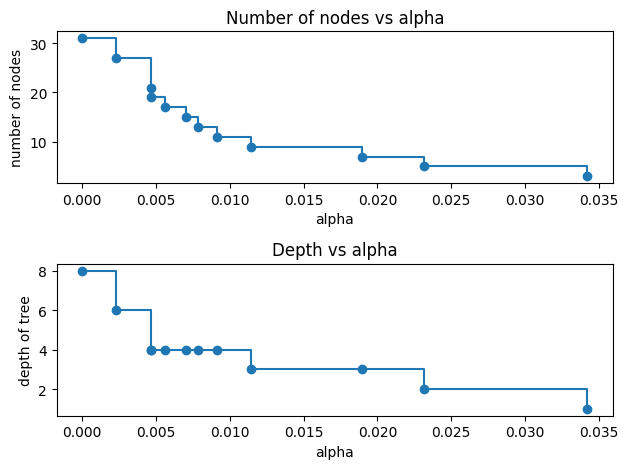

In [15]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

분류 나무에서 `.score` method는 정확도를 측정한다.

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

In [17]:
test_scores

[0.8811188811188811,
 0.8881118881118881,
 0.916083916083916,
 0.916083916083916,
 0.916083916083916,
 0.9230769230769231,
 0.9300699300699301,
 0.9300699300699301,
 0.9370629370629371,
 0.916083916083916,
 0.916083916083916,
 0.8811188811188811]

pruning parameter $\alpha$(`ccp_alpha`) 에 따른 train/test 정확도 변화를 시각화해 보자.

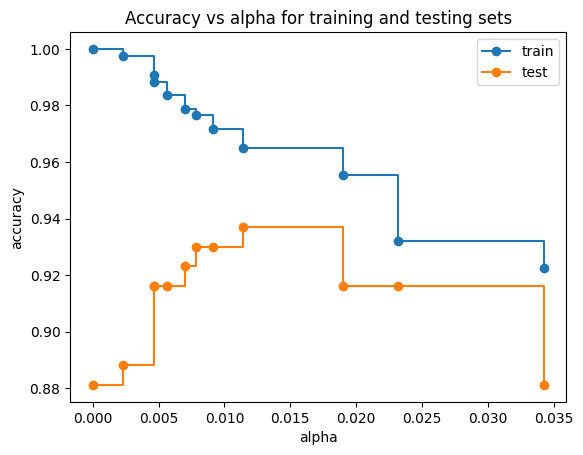

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

가장 좋은 test score를 가지는 tree를 찾아 그려 보자.

[Text(0.5, 0.875, 'x[7] <= 0.049\ngini = 0.468\nsamples = 426\nvalue = [159, 267]'),
 Text(0.25, 0.625, 'x[23] <= 952.9\ngini = 0.095\nsamples = 260\nvalue = [13, 247]'),
 Text(0.125, 0.375, 'gini = 0.054\nsamples = 252\nvalue = [7, 245]'),
 Text(0.375, 0.375, 'gini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.75, 0.625, 'x[23] <= 785.8\ngini = 0.212\nsamples = 166\nvalue = [146, 20]'),
 Text(0.625, 0.375, 'x[21] <= 23.74\ngini = 0.491\nsamples = 30\nvalue = [13, 17]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(0.75, 0.125, 'gini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(0.875, 0.375, 'gini = 0.043\nsamples = 136\nvalue = [133, 3]')]

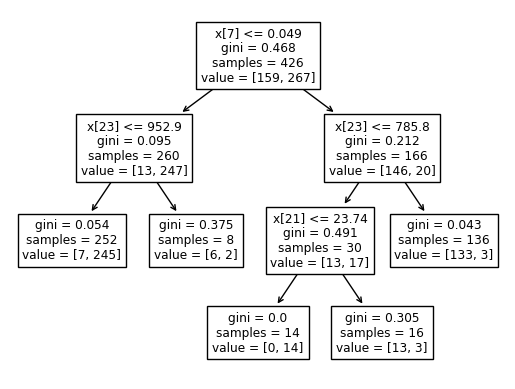

In [19]:
best_index = test_scores.index(max(test_scores))
tree.plot_tree(clfs[best_index])

한편, 가장 큰 트리는 다음과 같다.

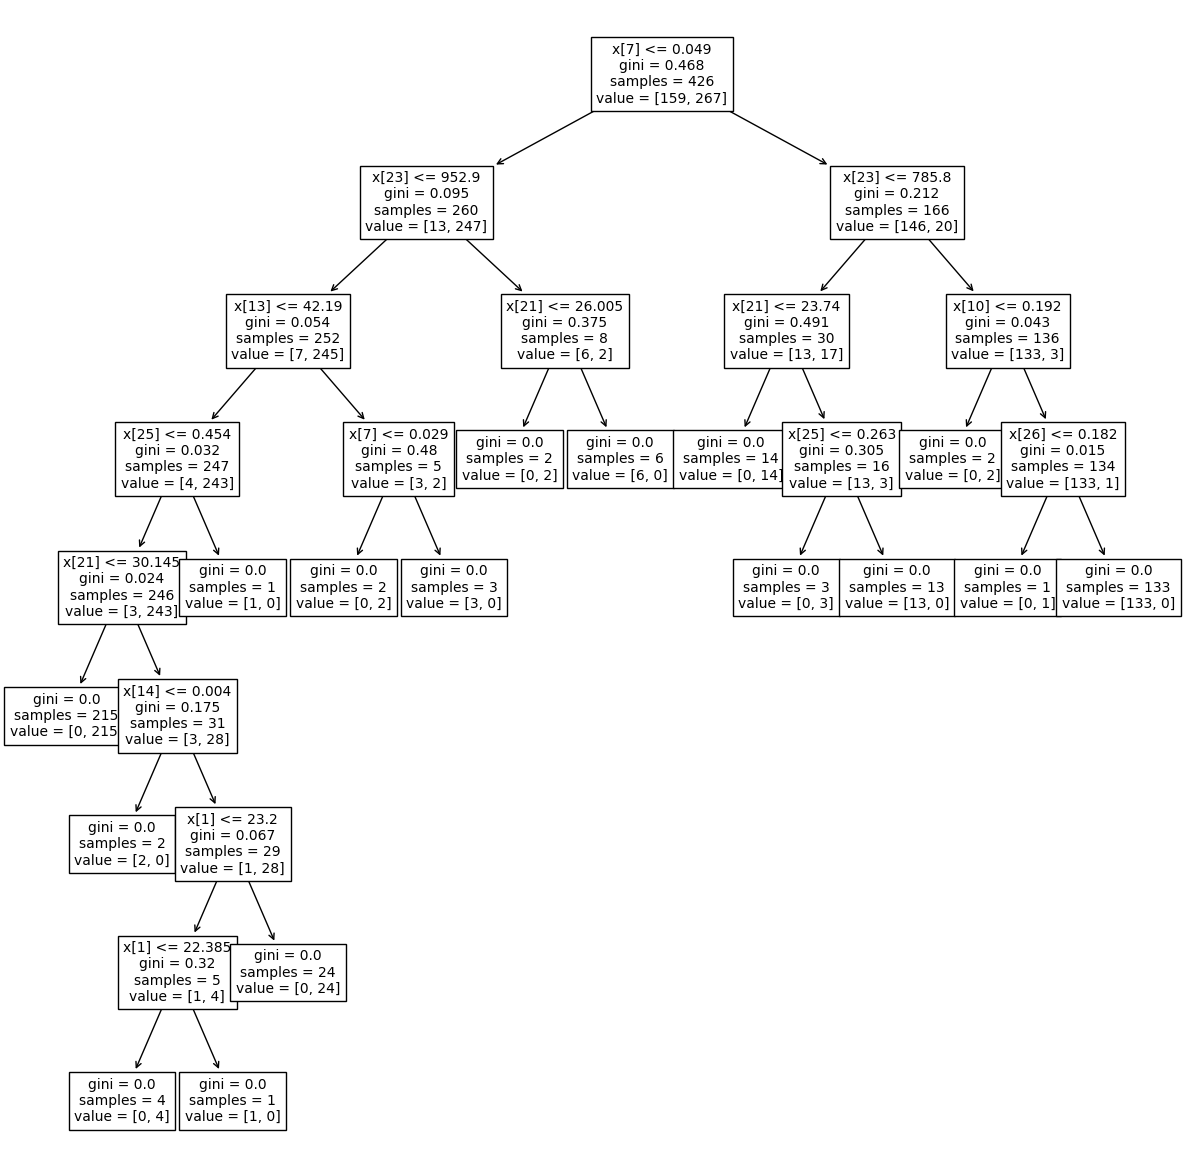

In [20]:
plt.figure(figsize=(15,15))  # set plot size (denoted in inches)

_ = tree.plot_tree(clfs[0] , fontsize=10)

여기서 weakest link를 자른 두 번째 트리이다.

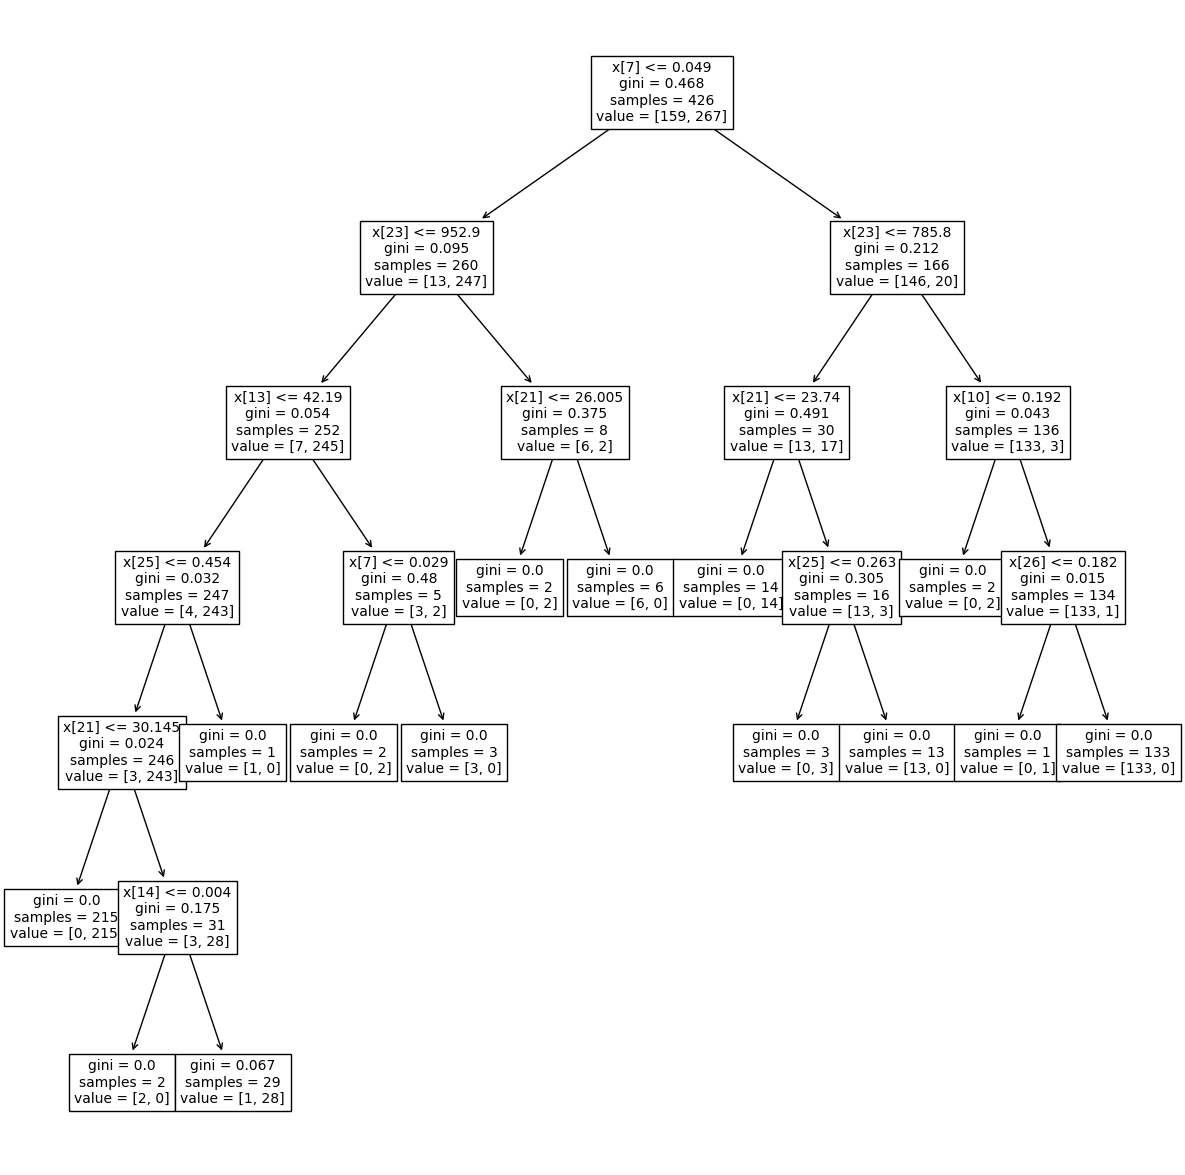

In [21]:
plt.figure(figsize=(15,15))  # set plot size (denoted in inches)

_ = tree.plot_tree(clfs[1] , fontsize=10)